In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import copy


import matplotlib.pyplot as plt




In [11]:
data = pd.read_csv('data_croped.csv', index_col = 0)
tp = pd.read_csv('tp_croped.csv', index_col = 0)

### Full Data

In [12]:
stacked_data = pd.DataFrame()

for i in tp.columns:
    stack = pd.concat([data, tp[i]], axis=1)
    stack = stack.rename(columns={tp[i].name: 'target'})
    stacked_data = pd.concat([stacked_data, stack], axis=0 )

stacked_data.dropna(inplace=True)

print(stacked_data.shape)

(44856, 50)


In [13]:
# --- Paramètres ---
window_size = 38

# --- 1. Extraction de X et y ---
y = stacked_data['target']  # Assigner 'target' à y
stacked_data.drop('target', axis=1, inplace=True)
y_lag = y.shift(1)
y_lag.iloc[0] = y_lag.iloc[1]
y_raw = y.values.astype(np.int32)

stacked_data['ylag'] = y_lag
X_raw = stacked_data.values.astype(np.float32)


# --- 2. Standardisation ---
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)

### Classic data

In [14]:
# --- Paramètres ---
window_size = 38

# --- 1. Extraction de X et y ---
y = tp[tp.columns[-1]]
y_lag = y.shift(1)
y_lag.iloc[0] = y_lag.iloc[1]
y_raw = y.values.astype(np.int32)

data['ylag'] = y_lag
X_raw = data.values.astype(np.float32)


# --- 2. Standardisation ---
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)

In [15]:
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_raw, window_size)

In [16]:
print(X_seq.shape)
print(data.shape)

(418, 38, 50)
(456, 50)


rapport classe négative / classe positive = 0.5344827586206896
tensor([0.5345])
Epoch 1/40, Train Loss: 0.4715, Val Loss: 0.5500
Epoch 2/40, Train Loss: 0.3954, Val Loss: 0.5153
Epoch 3/40, Train Loss: 0.2868, Val Loss: 0.4855
Epoch 4/40, Train Loss: 0.1977, Val Loss: 0.4745
Epoch 5/40, Train Loss: 0.1321, Val Loss: 0.4904
Epoch 6/40, Train Loss: 0.1204, Val Loss: 0.4770
Early stopping triggered.


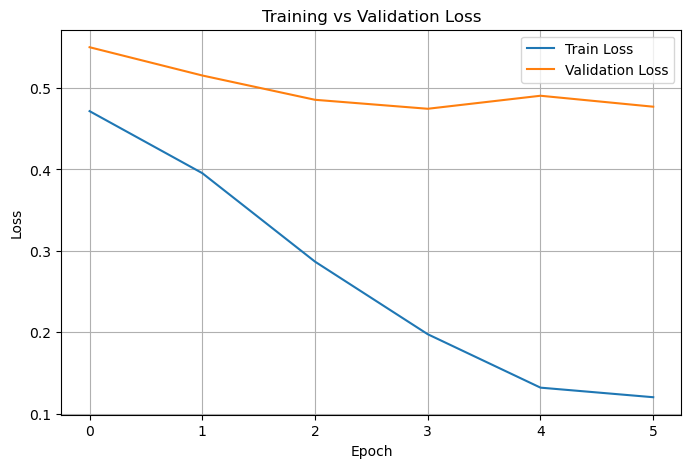

[[18  0]
 [34 32]]
              precision    recall  f1-score   support

         0.0      0.346     1.000     0.514        18
         1.0      1.000     0.485     0.653        66

    accuracy                          0.595        84
   macro avg      0.673     0.742     0.584        84
weighted avg      0.860     0.595     0.623        84

AUC: 0.8442760942760943


In [17]:
# --- 2. Dataset PyTorch ---
class TimeSeriesClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- 3. Split temporel train/test ---
train_val_split = int(0.8 * len(X_seq))
X_trainval, y_trainval = X_seq[:train_val_split], y_seq[:train_val_split]
X_test, y_test = X_seq[train_val_split:], y_seq[train_val_split:]

train_split = int(0.8 * len(X_trainval))  # 80% pour train, 20% pour val
X_train, y_train = X_trainval[:train_split], y_trainval[:train_split]
X_val, y_val = X_trainval[train_split:], y_trainval[train_split:]

train_loader = DataLoader(TimeSeriesClassificationDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TimeSeriesClassificationDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader = DataLoader(TimeSeriesClassificationDataset(X_test, y_test), batch_size=32, shuffle=False)

# --- 4. Modèle LSTM pour classification ---
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.5, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_size*self.num_directions, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Prend la dernière sortie et applique le dropout
        out = self.fc(out)
        return out.squeeze()

model = LSTMClassifier(input_size=X_seq.shape[2], hidden_size=64, num_layers=2, bidirectional = True, dropout=0.3)

# --- 5. Entraînement ---

n_pos = np.sum(y_train)
n_neg = len(y_train) - n_pos
print('rapport classe négative / classe positive =', n_neg / n_pos)
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32) #weighted loss pour gérer les classes déséquilibrées
print(pos_weight)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 40

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 2
counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # --- Validation ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # --- Early stoping

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter = 0
        best_model = copy.deepcopy(model.state_dict())
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# --- 6. Prédiction ---
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)
        probs = torch.sigmoid(logits)
        predictions.extend(probs.numpy())
        targets.extend(y_batch.numpy())

pred_classes = [1 if p >= 0.5 else 0 for p in predictions]

# --- 7. Évaluation ---
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

print(confusion_matrix(targets, pred_classes))
print(classification_report(targets, pred_classes, digits=3))
print("AUC:", roc_auc_score(targets, predictions))




In [18]:
n_pos = np.sum(y_train)
n_neg = len(y_train) - n_pos
print('rapport train classe négative / classe positive =', n_neg / n_pos)

n_pos = np.sum(y_test)
n_neg = len(y_test) - n_pos
print('rapport test  négative / classe positive =', n_neg / n_pos)

rapport train classe négative / classe positive = 0.5344827586206896
rapport test  négative / classe positive = 0.2727272727272727
